In [1]:
import os
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ['CUDA_VISIBLE_DEVICES'] = '0'

In [2]:
import os
from shutil import copyfile, rmtree, copy, move, unpack_archive
from tqdm.notebook import tqdm
import torch
import torchaudio
from torchaudio import transforms
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt

## Данные
Скачаем файлы, распакуем, раскидаем нужные файлы по папкам с переименованиям (*лейбл_названиефайла.wav*)

In [3]:
!wget https://datashare.ed.ac.uk/bitstream/handle/10283/3061/vcc2018_database_training.zip?sequence=2&isAllowed=y
!wget https://datashare.ed.ac.uk/bitstream/handle/10283/3061/vcc2018_database_evaluation.zip?sequence=3&isAllowed=y

In [4]:
unpack_archive('vcc2018_database_training.zip', 'vcc2018_database_training')
unpack_archive('vcc2018_database_evaluation.zip', 'vcc2018_database_evaluation')

In [5]:
try:
    os.mkdir('train')
except OSError as error:
    pass 
for dir_nm in os.listdir('vcc2018_database_training/vcc2018_training'):
    if "VCC2S" in dir_nm:
        for file_nm in tqdm(os.listdir('vcc2018_database_training/vcc2018_training/' + dir_nm)):
            copy('vcc2018_database_training/vcc2018_training/' + dir_nm + '/' + file_nm, 'train/' + dir_nm + "_" + file_nm)

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

  0%|          | 0/81 [00:00<?, ?it/s]

In [6]:
try:
    os.mkdir('test')
except OSError as error:
    pass 
for dir_nm in os.listdir('vcc2018_database_evaluation/vcc2018_evaluation'):
    if "VCC2S" in dir_nm:
        for file_nm in tqdm(os.listdir('vcc2018_database_evaluation/vcc2018_evaluation/' + dir_nm)):
            copy('vcc2018_database_evaluation/vcc2018_evaluation/' + dir_nm + '/' + file_nm, 'test/' + dir_nm + "_" + file_nm)

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/35 [00:00<?, ?it/s]

## Данные

In [7]:
lengths = []
chanels = set()
srs = set()
for audio_file in tqdm(os.listdir('train')):
    sig, sr = torchaudio.load('train/' + audio_file)
    chanels.add(sig.shape[0])
    srs.add(sr)
    lengths.append(sig.shape[1] / sr)

  0%|          | 0/648 [00:00<?, ?it/s]

Все входные данные одноканальные:

In [8]:
chanels

{1}

Все файлы имеют одинаковую частоту дискретизации

In [9]:
srs

{22050}

В среднем дорожка идет 3.5 секунды, самая длинная порядка 10 секунд, а самая короткая меньше секунды

In [10]:
np.mean(lengths), np.max(lengths), np.min(lengths)

(3.495423490383808, 10.715873015873015, 0.9080272108843538)

## Метки

In [11]:
import pandas as pd
last_label = 0
train_data = pd.DataFrame(columns = ['name', 'label'])
labels_dict = dict()
for file in tqdm(os.listdir('train')):
    if file[:7] not in labels_dict:
        labels_dict[file[:7]] = last_label
        last_label += 1
    train_data = train_data.append({'name' : 'train/'+file, 'label': labels_dict[file[:7]]}, ignore_index=True)
train_data

  0%|          | 0/648 [00:00<?, ?it/s]

,name,label
0,train/VCC2SM3_20019.wav,0
1,train/VCC2SM2_10069.wav,1
2,train/VCC2SM1_10049.wav,2
3,train/VCC2SF1_10042.wav,3
4,train/VCC2SM2_10040.wav,1
...,...,...
643,train/VCC2SF4_20010.wav,7
644,train/VCC2SF3_20024.wav,5
645,train/VCC2SF2_10002.wav,4
646,train/VCC2SM4_20034.wav,6


In [12]:
test_data = pd.DataFrame(columns = ['name', 'label'])

for file in tqdm(os.listdir('test')):
    test_data = test_data.append({'name' : 'test/' + file, 'label': labels_dict[file[:7]]}, ignore_index=True)
test_data

  0%|          | 0/280 [00:00<?, ?it/s]

,name,label
0,test/VCC2SF4_30021.wav,7
1,test/VCC2SM2_30009.wav,1
2,test/VCC2SM3_30001.wav,0
3,test/VCC2SM1_30029.wav,2
4,test/VCC2SF1_30026.wav,3
...,...,...
275,test/VCC2SM4_30019.wav,6
276,test/VCC2SM3_30012.wav,0
277,test/VCC2SF4_30033.wav,7
278,test/VCC2SM2_30024.wav,1


In [13]:
labels_dict

{'VCC2SM3': 0,
 'VCC2SM2': 1,
 'VCC2SM1': 2,
 'VCC2SF1': 3,
 'VCC2SF2': 4,
 'VCC2SF3': 5,
 'VCC2SM4': 6,
 'VCC2SF4': 7}

## Класс-датасет

Данные будем все приводить к единообразному состоянию (в данном случае достаточно перегонки в одну длину, например, 5 секунд, путем паддинга или обрезания), немножко аугментировать (сдвиг по времени) и получать их мел-спектрограммы

In [14]:
from torch.utils.data import DataLoader, Dataset, random_split

class SoundDataset(Dataset):
    def __init__(self, data, length = 5000, max_shift = 0.2, n_mels=64, n_fft=1024, hop_length=None):
        self.data = data
        self.length = length
        self.max_shift = max_shift
        self.n_mels = n_mels
        self.n_fft = n_fft
        self.hop_length = hop_length
    def __len__(self):
        return len(self.data)    
    
    def __getitem__(self, idx):
        audio_file = self.data.loc[idx, 'name']
        label = self.data.loc[idx, 'label']

        audio = torchaudio.load(audio_file)

        audio = self.adjusting_length(audio)
        audio = self.time_shift(audio)
        
        audio = self.spectro_gram(audio)

        return audio, label   
    
    def adjusting_length(self, audio):
        sig, sr = audio
        num_rows, sig_len = sig.shape
        sample_length = sr * self.length // 1000

        if (sig_len > sample_length):
            sig = sig[:, :sample_length]

        elif (sig_len < sample_length):
            pad_begin_len = np.random.randint(0, sample_length - sig_len)
            pad_end_len = sample_length - sig_len - pad_begin_len

            pad_begin = torch.zeros((num_rows, pad_begin_len))
            pad_end = torch.zeros((num_rows, pad_end_len))

            sig = torch.cat((pad_begin, sig, pad_end), 1)

        return (sig, sr)
    
    def time_shift(self, audio):
        sig, sr = audio
        _, sig_len = sig.shape
        shift_amt = int(np.random.random() * self.max_shift * sig_len)
        return (sig.roll(shift_amt), sr)
    
    def spectro_gram(self, audio):
        sig, sr = audio
        top_db = 80

        spec = transforms.MelSpectrogram(sr, n_fft=self.n_fft, hop_length=self.hop_length, n_mels=self.n_mels)(sig)

        spec = transforms.AmplitudeToDB(top_db=top_db)(spec)
        return (spec)    

In [15]:
dataset = SoundDataset(train_data)

num_items = len(dataset)
num_train = round(num_items * 0.8)
num_val = num_items - num_train
train_dataset, val_dataset = random_split(dataset, [num_train, num_val])

train_dataloader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_dataloader = DataLoader(val_dataset, batch_size=16, shuffle=False)

In [16]:
len(dataset), len(train_dataset), len(val_dataset)

(648, 518, 130)

In [17]:
dataset[5][0].shape

torch.Size([1, 64, 216])

## Модель


In [18]:
import torch.nn.functional as F
from torch.nn import init
from torch import nn

class AudioClassifier(torch.nn.Module):
    def __init__(self, num_classes = 8):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 8, kernel_size=(5, 5), stride=(2, 2), padding=(2, 2))
        self.relu1 = nn.ReLU()
        self.bn1 = nn.BatchNorm2d(8)

        self.conv2 = nn.Conv2d(8, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu2 = nn.ReLU()
        self.bn2 = nn.BatchNorm2d(16)

        self.conv3 = nn.Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu3 = nn.ReLU()
        self.bn3 = nn.BatchNorm2d(32)

        self.conv4 = nn.Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu4 = nn.ReLU()
        self.bn4 = nn.BatchNorm2d(64)
        
        self.conv5 = nn.Conv2d(64, 128, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
        self.relu5 = nn.ReLU()
        self.bn5 = nn.BatchNorm2d(128)

        self.conv_blocks = nn.Sequential(self.conv1, self.relu1, self.bn1,
                                         self.conv2, self.relu2, self.bn2,
                                         self.conv3, self.relu3, self.bn3,
                                         self.conv4, self.relu4, self.bn4,
                                         self.conv5, self.relu5, self.bn5
                                        )
        
        self.avgpool = nn.AdaptiveAvgPool2d(output_size=1)
        self.linear = nn.Linear(in_features=128, out_features=num_classes)
 
    def forward(self, x):
        x = self.conv_blocks(x)
        x = self.avgpool(x)
        return self.linear(x.view(x.shape[0], -1))

In [19]:
myModel = AudioClassifier()
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
myModel = myModel.to(device)

## Обучение

In [20]:
def training(model, train_dataloader, val_dataloader, num_epochs, criterion, optimizer, scheduler, 
             train_loss=None, val_loss = None, train_acc = None, val_acc = None):
    if train_loss is None:
        train_loss = []
    if val_loss is None:
        val_loss = []
    if train_acc is None:
        train_acc = []
    if val_acc is None:
        val_acc = []
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for data in tqdm(train_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            optimizer.zero_grad()

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            scheduler.step()

            running_loss += loss.item()

            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        num_batches = len(train_dataloader)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
        train_loss.append(avg_loss)
        train_acc.append(acc)
        
        with torch.no_grad():
            running_loss = 0.0
            correct_prediction = 0
            total_prediction = 0

            for data in tqdm(val_dataloader):
                inputs, labels = data[0].to(device), data[1].to(device)

                inputs_m, inputs_s = inputs.mean(), inputs.std()
                inputs = (inputs - inputs_m) / inputs_s

                optimizer.zero_grad()

                outputs = model(inputs)
                loss = criterion(outputs, labels)

                running_loss += loss.item()

                _, prediction = torch.max(outputs,1)
                correct_prediction += (prediction == labels).sum().item()
                total_prediction += prediction.shape[0]

            num_batches = len(val_dataloader)
            avg_loss = running_loss / num_batches
            acc = correct_prediction / total_prediction
            val_loss.append(avg_loss)
            val_acc.append(acc)
            
        clear_output(wait=True)
        print("Epoch", epoch + 1)
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 16))
        ax1.plot(train_loss, label='Train loss')
        ax1.plot(val_loss, label='Val loss')
        ax1.set_title("Loss")
        ax2.plot(train_acc, label='Train acc')
        ax2.plot(val_acc, label='Val acc')
        ax2.set_title("Accuracy")
        ax1.legend()
        ax2.legend()
        plt.show()

Epoch 30


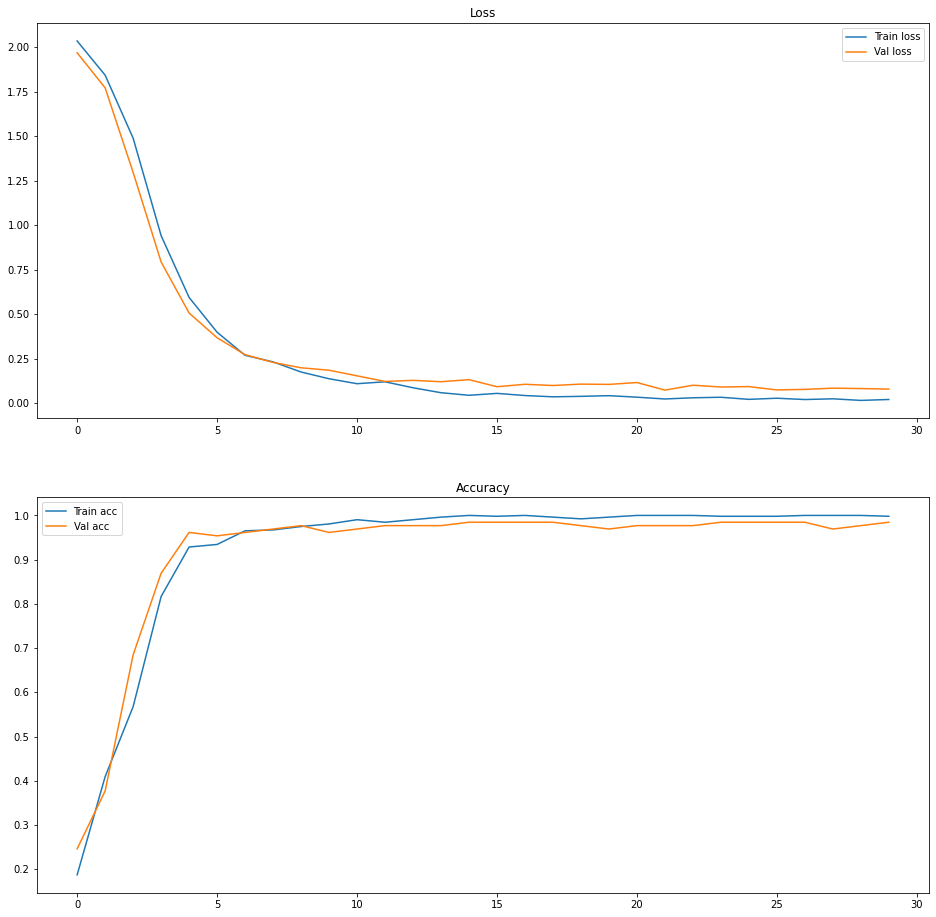

In [21]:
num_epochs = 30 

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(myModel.parameters(),lr=0.001)
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=0.001,
                                            steps_per_epoch=int(len(train_dataloader)),
                                            epochs=num_epochs,
                                            anneal_strategy='linear')

training(myModel, train_dataloader, val_dataloader, num_epochs, criterion, optimizer, scheduler)

## Тестирование

In [22]:
test_dataset = SoundDataset(test_data)
test_dataloader = DataLoader(test_dataset, batch_size=16, shuffle=False)

def inference(model, test_dataloader, criterion):
    print("Test...")
    with torch.no_grad():
        running_loss = 0.0
        correct_prediction = 0
        total_prediction = 0

        for data in tqdm(test_dataloader):
            inputs, labels = data[0].to(device), data[1].to(device)

            inputs_m, inputs_s = inputs.mean(), inputs.std()
            inputs = (inputs - inputs_m) / inputs_s

            outputs = model(inputs)
            loss = criterion(outputs, labels)

            running_loss += loss.item()

            _, prediction = torch.max(outputs,1)
            correct_prediction += (prediction == labels).sum().item()
            total_prediction += prediction.shape[0]

        num_batches = len(test_dataloader)
        avg_loss = running_loss / num_batches
        acc = correct_prediction / total_prediction
    print("Loss:", avg_loss, "\nAccuracy:", acc)

inference(myModel, test_dataloader, criterion)

Test...


  0%|          | 0/18 [00:00<?, ?it/s]

Loss: 0.044232381055028074 
Accuracy: 0.9964285714285714
